In [14]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation,TimeDistributed
from keras.layers import Bidirectional, LSTM
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate,BatchNormalization,MaxPooling1D, Convolution1D
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D, RepeatVector, Permute, merge
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import concatenate
from keras.callbacks import *
from keras.utils import to_categorical


In [2]:
import keras
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)

keras.backend.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
#google word2vec
# from gensim.models import KeyedVectors as wv
# word_vectors = wv.load_word2vec_format('./input/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin', binary = True)
# EMBEDDING_DIM =300

#glove
word_vectors = {}
f = open('./input/embeddings/glove.840B.300d/glove.840B.300d.txt')
for line in f:
    values = line.split()
    word = ''.join(values[:-300])
    coefs = np.asarray(values[-300:], dtype='float32')
    word_vectors[word] = coefs
f.close()
EMBEDDING_DIM =300

# print('Found %s word vectors.' % len(embeddings_index))

In [5]:
# df_train = pd.read_csv("./input/train.csv")
# df_test = pd.read_csv("./input/test.csv")

df = pd.read_csv("./input/train.csv")
df_train, df_test = train_test_split(df, test_size=0.2,random_state=1)
print("Train shape : ",df_train.shape)
print("Test shape : ",df_test.shape)

df_train_pos = df_train[df_train['target']==1]
df_train_neg = df_train[df_train['target']==0].sample(len(df_train_pos)*5,random_state=1)
df_train = pd.concat([df_train_pos,df_train_neg])
df_train = df_train.sample(frac=1,random_state=1)
print("Train shape : ",df_train.shape)

df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

MAX_SEQUENCE_LENGTH=150


tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(df_train['question_text'])
sequences = tokenizer.texts_to_sequences(df_train['question_text'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

train_X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
train_Y = df_train['target']

sequences = tokenizer.texts_to_sequences(df_test['question_text'])
test_X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
test_Y = df_test['target']
# labels = to_categorical(np.asarray(labels))
# print('Shape of data tensor:', data.shape)
# print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
# indices = np.arange(data.shape[0])
# np.random.shuffle(indices)
# data = data[indices]
# labels = labels[indices]
# nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

# x_train = data[:-nb_validation_samples]
# y_train = labels[:-nb_validation_samples]
# x_val = data[-nb_validation_samples:]
# y_val = labels[-nb_validation_samples:]

Train shape :  (1044897, 3)
Test shape :  (261225, 3)
Train shape :  (387192, 3)


/home/samarth/anaconda3/envs/tensorflow36/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Found 133472 unique tokens.


In [6]:

df_train.iloc[4]['question_text']

'What can make you effective teacher?'

73.65645984421165
62.0
41.84467927436718
1017


(array([3.15713e+05, 6.37790e+04, 7.69500e+03, 3.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([1.000e+00, 1.026e+02, 2.042e+02, 3.058e+02, 4.074e+02, 5.090e+02,
        6.106e+02, 7.122e+02, 8.138e+02, 9.154e+02, 1.017e+03]),
 <a list of 10 Patch objects>)

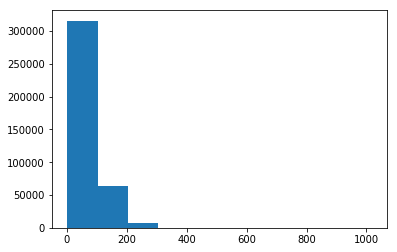

In [7]:
lengths = []
for sent in df_train['question_text']:
#     print(sent)
    lengths.append(len(sent))
#     if max(sent)>50:
#         print(sent)
print(np.mean(lengths))
print(np.median(lengths))
print(np.std(lengths))
print(np.max(lengths))
plt.hist(lengths,density=False)

In [8]:
#for google word2vec

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        word_vector = word_vectors[word]
#     if word_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = word_vector
    except KeyError:
        continue

In [9]:
# print(train_X_raw[0])
print(train_X.shape)
print(train_Y.shape)
# print(tokenizer.word_index)

(387192, 150)
(387192,)


In [10]:
def f1(y_true, y_pred):
    '''
    metric from here 
    https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
    '''
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    # So we only measure F1 on the target y value:
    y_true = y_true[:, 0]
    y_pred = y_pred[:, 0]
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [16]:
##model definition
# model = Sequential()
dropout_prob = [0.2,0.2]
hidden_dims = 50
filter_sizes  = (3,8)
num_filters = 10

input_shape = (MAX_SEQUENCE_LENGTH,)
model_input = Input(shape=input_shape)

z = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)(model_input)

conv_blocks = []
for sz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=sz,
                         padding="valid",
                         activation="relu",
                         strides=1)(z)
    conv = MaxPooling1D(pool_size=2)(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

z = Dropout(dropout_prob[1])(z)
z = Dense(hidden_dims, activation="relu")(z)
model_output = Dense(1, activation="sigmoid")(z)

model = Model(model_input, model_output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 150, 300)     40041900    input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 148, 10)      9010        embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 143, 10)      24010       embedding_5[0][0]                
__________________________________________________________________________________________________
max_poolin

In [ ]:
model.fit(train_X, train_Y, epochs=10,batch_size=500,validation_split=0.1)

Train on 348472 samples, validate on 38720 samples
Epoch 1/10
348472/348472 [==============================] - 19s 54us/step - loss: 0.2287 - acc: 0.9051 - val_loss: 0.1999 - val_acc: 0.9184
Epoch 2/10
171000/348472 [=============>................] - ETA: 6s - loss: 0.2033 - acc: 0.9169

In [28]:
preds= model.predict_classes(test_X,verbose=1,batch_size=5000)
print(metrics.f1_score(test_Y, preds))
# pred_cnn_val_y = model.predict([val_X], batch_size=1024, verbose=1)


261225/261225 [==============================] - 31s 119us/step
0.6395928956296147


In [18]:
for thresh in np.arange(-0.20, 1, 0.05):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(train_Y, (preds>thresh).astype(int))))

F1 score at threshold -0.2 is 0.5
F1 score at threshold -0.15 is 0.5
F1 score at threshold -0.1 is 0.5
F1 score at threshold -0.05 is 0.5
F1 score at threshold -0.0 is 0.5006551699569726
F1 score at threshold 0.05 is 0.9538913433701808
F1 score at threshold 0.1 is 0.9588053741119749
F1 score at threshold 0.15 is 0.9608015640273705
F1 score at threshold 0.2 is 0.9622097119018885
F1 score at threshold 0.25 is 0.9630757144260041
F1 score at threshold 0.3 is 0.9636065150425176
F1 score at threshold 0.35 is 0.9639653505882643
F1 score at threshold 0.4 is 0.9641520716588683
F1 score at threshold 0.45 is 0.964307977164018
F1 score at threshold 0.5 is 0.9644417258274791
F1 score at threshold 0.55 is 0.9646491200940216
F1 score at threshold 0.6 is 0.9645400611848054
F1 score at threshold 0.65 is 0.964271098158368
F1 score at threshold 0.7 is 0.9639306803434937
F1 score at threshold 0.75 is 0.9634884906669319
F1 score at threshold 0.8 is 0.9628457710203242
F1 score at threshold 0.85 is 0.9619818

In [25]:
preds = model.predict_classes(test_X,verbose=1)
# print(metrics.f1_score(train_Y,preds))
print(sum(preds))

56370/56370 [==============================] - 9s 163us/step
[7259]


In [26]:
df_out = pd.DataFrame()
df_out["qid"] = df_test['qid']
df_out["predictions"] = preds
df_out.to_csv("sub.csv",index=False)

In [22]:
sum(preds)

array([81037], dtype=int32)

## Attention Layer